In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def unemployment_clean(df, year, month):
    df['Date'] = pd.to_datetime((df[year].map(str) + "-" + df[month].str[1:] + "-01"), format = "%Y-%m-%d").dt.date
    df.rename(index=str, columns={'Value':'Unemployment Rate'}, inplace=True)
    df.drop(columns=['Series id', year, 'Period'], inplace=True)

    return df

def dow_clean(df, date, close):
    df['adjDate'] = pd.to_datetime(df[date], format = "%m/%d/%Y").dt.date
    newDF = pd.DataFrame(df[['adjDate', close]])
    newDF.rename(index=str, columns={'adjDate':'Date', 'Close':'Dow Jones Price'}, inplace=True)
    newDF['Dow Jones Price'] = newDF['Dow Jones Price'].apply(lambda x: round(x,2))
    
    return newDF


def cpi_clean(df, year, month):
    #x = pd.Series(df[year].map(str) + "-" + df[month].str[1:] + "-01")
    df['Date'] = pd.to_datetime((df[year].map(str) + "-" + df[month].str[1:] + "-01"), format = "%Y-%m-%d").dt.date
    df.rename(index=str, columns={'Value':'CPI'}, inplace=True)
    
    #df.drop(columns=['footnote_codes'], inplace=True)
    df.sort_values('Date', ascending=False, inplace=True)
    df['CPI'] = df['CPI'].apply(lambda x: round(x,1))
    
    #some "Periods" contain 'MXX', we need to drop the 'M's
    df = df[df['Period'].str.contains("M")]
    return df


def fed_funds_clean(fed_funds_df):
    #remove header
    df = pd.DataFrame(fed_funds_df[5:])
    
    #change column name
    df.rename(index=str, columns={'Federal funds effective rate': 'Fed Funds Rate'}, inplace=True)
    
    #convert date to datetime
    df['Date'] = pd.to_datetime((df['Series Description'].str[0:4] + "-" + df['Series Description'].str[5:] + "-01"), format = "%Y-%m-%d").dt.date
    
    #drop old date column, 'Series Description'
    df.drop(columns='Series Description', inplace=True)
    
    return df


def merge_all_dataframes(dow, fed_funds, cpi, unemployment):
    dfs = [dow, fed_funds, cpi, unemployment]
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
    df_final.drop(columns=['Series Id', 'Year', 'Period'], inplace=True)
    return df_final

## Import and clean Dow Jones Price data

In [3]:
dow_jones = pd.read_csv('dow_jones_prices.csv')
df_dow = dow_clean(dow_jones, 'Date', 'Close')
df_dow.head()

,Date,Dow Jones Price
0,1985-01-01,1286.77
1,1985-02-01,1284.01
2,1985-03-01,1266.78
3,1985-04-01,1258.06
4,1985-05-01,1315.41


## Import and clean Unemployment data

In [4]:
unemployment_data = pd.read_csv('unemployed.csv')
df_unemployment = unemployment_clean(unemployment_data, 'Year', 'Period')
df_unemployment.head()

,Unemployment Rate,Date
0,3.4,1948-01-01
1,3.8,1948-02-01
2,4.0,1948-03-01
3,3.9,1948-04-01
4,3.5,1948-05-01


## Import and clean CPI data

In [5]:
cpi = pd.read_csv('cpi.csv')
df_cpi = cpi_clean(cpi, 'Year', 'Period')
df_cpi.head()

,Series Id,Year,Period,CPI,Date
1328,CUUR0000SA0,2018,M01,247.9,2018-01-01
1325,CUUR0000SA0,2017,M12,246.5,2017-12-01
1324,CUUR0000SA0,2017,M11,246.7,2017-11-01
1323,CUUR0000SA0,2017,M10,246.7,2017-10-01
1322,CUUR0000SA0,2017,M09,246.8,2017-09-01


## Import and clean Fed Funds data

In [6]:
fed_funds = pd.read_csv('fed_funds.csv')
df_fed_funds = fed_funds_clean(fed_funds)
df_fed_funds.head()

,Fed Funds Rate,Date
5,0.8,1954-07-01
6,1.22,1954-08-01
7,1.06,1954-09-01
8,0.85,1954-10-01
9,0.83,1954-11-01


## Merge all dataframes

In [7]:
df = merge_all_dataframes(df_dow, df_fed_funds, df_cpi, df_unemployment)
df.head()

,Date,Dow Jones Price,Fed Funds Rate,CPI,Unemployment Rate
0,1985-01-01,1286.77,8.35,105.5,7.3
1,1985-02-01,1284.01,8.5,106.0,7.2
2,1985-03-01,1266.78,8.58,106.4,7.2
3,1985-04-01,1258.06,8.27,106.9,7.3
4,1985-05-01,1315.41,7.97,107.3,7.2


## Let's first try and predict the dow using only one feature

#### First, let's use the fed funds rate

In [8]:
columns = ['Fed Funds Rate']

In [9]:
x = df[columns]
y = df['Dow Jones Price']
model = linear_model.LinearRegression()
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
model.coef_

array([-1372.69914471])

In [11]:
model.intercept_

13964.92953617147

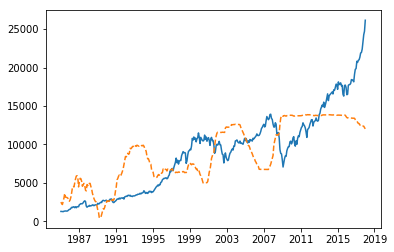

In [12]:
#plt.figure(num=1, figsize=(12, 8))
plt.plot(df['Date'],df['Dow Jones Price'],'-')
plt.plot(df['Date'], model.predict(x),'--')

#### Yikes! That doesn't look good.  Let's try a prediction using CPI data

In [13]:
columns = ['CPI']

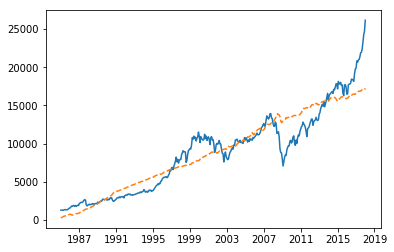

In [14]:
x = df[columns]
y = df['Dow Jones Price']
model = linear_model.LinearRegression()
model.fit(x,y)
#plt.figure(num=1, figsize=(12, 8))
plt.plot(df['Date'],df['Dow Jones Price'],'-')
plt.plot(df['Date'], model.predict(x),'--')

#### This looks better.  But it still doesn't look good.  Finally, what about the Unemployment rate as a predictor?

In [15]:
columns = ['Unemployment Rate']

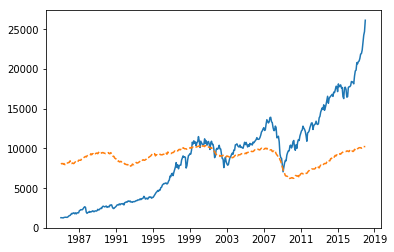

In [16]:
x = df[columns]
y = df['Dow Jones Price']
model = linear_model.LinearRegression()
model.fit(x,y)
#plt.figure(num=1, figsize=(12, 8))
plt.plot(df['Date'],df['Dow Jones Price'],'-')
plt.plot(df['Date'], model.predict(x),'--')

#### We're getting worse.  Though note this does exhibit a sinusoidal pattern which reflects the ebb and flow of economic cycles

## Enough messing around, let's combine all the features and run a multiple regression

In [17]:
columns = ['Fed Funds Rate', 'CPI', 'Unemployment Rate']

In [18]:
x = df[columns]
y = df['Dow Jones Price']
model = linear_model.LinearRegression()
model.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
model.coef_

array([ -54.06113175,  118.59299918, -982.21203152])

In [20]:
model.intercept_

-6095.64149855428

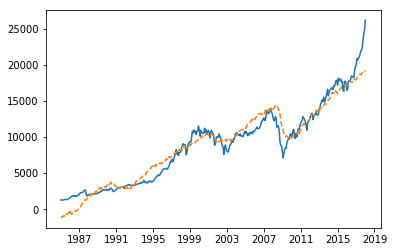

In [21]:
#plt.figure(num=1, figsize=(12, 8))
plt.plot(df['Date'],df['Dow Jones Price'],'-')
plt.plot(df['Date'], model.predict(x),'--')

## Much better! Though we see variance at the edges, we finally have a decent fit. 

#### Note: This was a simple example.  It did not include any training/test set, cross-validation, feature normalization or regularization.  If your goal was to use this model for predicting the stock market, you would want to go a few steps further.